# GRAIN G600:
Modelos de clasificación de trigo y maiz, se entrena un modelo para clasificar todo el grano.

In [1]:
!pip install keras-tuner -q
!pip install tensorboard -q

In [2]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Activation
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping
import keras_tuner as kt

from tensorflow.keras.preprocessing.image import ImageDataGenerator

import matplotlib.pyplot as plt
from tqdm import tqdm
import datetime


print(tf.__version__)
#-------------------------------------------------------------------------------
import time

import numpy as np
from tensorflow import keras



c:\anaconda3\envs\TFenv\lib\site-packages\scipy\__init__.py:138: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.4)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion} is required for this version of "


2.10.1


Iniciamos configurando tensorflow para usar la GPU, al igual que tensorboard

In [3]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

if len(tf.config.list_physical_devices('GPU'))>0:
    physical_devices = tf.config.list_physical_devices('GPU')
    print(physical_devices)
    tf.config.experimental.set_virtual_device_configuration(physical_devices[0], [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=4096)])
    print("Virtual GPU devices: ", tf.config.list_logical_devices('GPU'))

Num GPUs Available:  1
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Virtual GPU devices:  [LogicalDevice(name='/device:GPU:0', device_type='GPU')]


In [4]:
tf.debugging.set_log_device_placement(False)

## Ambos granos: Trigo y Maiz
Generamos dos iteradores de carpetas para los conjuntos de datos de validación y de entrenamiento.

In [5]:
# Directorios de entrenamiento y validación r"../../grainspace/G600/pre/both/
train_dir = '../grainspace/G600/pre/both/train'
validation_dir = '../grainspace/G600/pre/both/validation'

datagen = ImageDataGenerator(
    rescale=1./255,          # Normaliza los valores de los píxeles
    shear_range=0.2,         # Aplica transformaciones de corte
    zoom_range=0.2,          # Aplica zoom aleatorio
    horizontal_flip=True     # Invierte las imágenes horizontalmente
)
train_generator = datagen.flow_from_directory(
    train_dir,  # Directorio con las imágenes de entrenamiento
    target_size=(150, 150),     # Tamaño de las imágenes
    batch_size=32,              # Tamaño del lote
    class_mode='categorical'         # Tipo de clasificación (binary, categorical, etc.)
)
validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical'
)







Found 77568 images belonging to 14 classes.
Found 31322 images belonging to 14 classes.


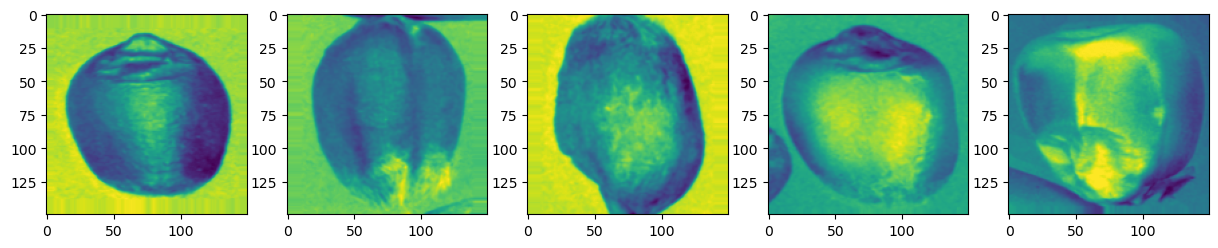

In [6]:
batch_images, batch_labels = next(train_generator)

# Assuming the images are in the first channel of the batch
sample_images = batch_images[:, :, :, 0]

# Plot the first few images
num_images_to_plot = 5
fig, axes = plt.subplots(1, num_images_to_plot, figsize=(15, 5))
for i in range(num_images_to_plot):
    axes[i].imshow(sample_images[i])
    axes[i].axis('on')
plt.show()

Definimos la arquitectura del modelo, a través de keras tuner:

In [7]:
print(train_generator.class_indices)

{'AP_maize': 0, 'AP_wheat': 1, 'BN_maize': 2, 'BN_wheat': 3, 'BP_wheat': 4, 'FM_maize': 5, 'FS_wheat': 6, 'HD_maize': 7, 'MY_maize': 8, 'MY_wheat': 9, 'NOR_maize': 10, 'NOR_wheat': 11, 'SD_maize': 12, 'SD_wheat': 13}


Define una función de construcción del modelo que incluya los hiperparámetros que deseas optimizar.

In [8]:
def build_model(hp):
    model = keras.Sequential()
    
    # Capas de convolución
    for i in range(hp.Int('conv_layers', 1, 3)):
        if i == 0:
            model.add(Conv2D(hp.Choice('conv_units', [32, 64, 128]), (3, 3), input_shape=(150, 150, 3)))
        else:
            model.add(Conv2D(hp.Choice('conv_units', [32, 64, 128]), (3, 3)))
        model.add(Activation('relu'))
        model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Flatten())
    
    # Capas densas
    for i in range(hp.Int('dense_layers', 0, 2)):
        model.add(Dense(hp.Choice('dense_units', [32, 64, 128])))
        model.add(Activation('relu'))
    
    model.add(Dropout(0.5))
    model.add(Dense(len(train_generator.class_indices)))
    model.add(Activation('softmax'))
    
    model.compile(
        optimizer=keras.optimizers.Adam(),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    
    return model

Configura el tuner para buscar los mejores hiperparámetros.



In [9]:
tuner = kt.Hyperband(
    build_model,
    objective='val_accuracy',
    max_epochs=5,
    factor=3,
    directory='logs',
    project_name='GrainG600_Keras_tuner'
)


Ejecuta la búsqueda de hiperparámetros.



In [16]:
tensorboard = TensorBoard(log_dir="logs/GrainG600_Keras_tuner/{}".format(int(time.time())))

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)



In [11]:
tuner.search(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size,
    epochs=10,
    callbacks=[tensorboard, early_stopping]
)


Trial 10 Complete [00h 25m 41s]
val_accuracy: 0.9304064512252808

Best val_accuracy So Far: 0.9304064512252808
Total elapsed time: 03h 18m 05s


Obtener los Mejores Hiperparámetros y Evaluar el Modelo

In [12]:
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"Mejores hiperparámetros: {best_hps.values}")

Mejores hiperparámetros: {'conv_layers': 3, 'conv_units': 128, 'dense_layers': 2, 'dense_units': 128, 'tuner/epochs': 5, 'tuner/initial_epoch': 0, 'tuner/bracket': 0, 'tuner/round': 0}


In [13]:

best_model = tuner.hypermodel.build(best_hps)
best_model.summary()

history = best_model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size,
    epochs=60,
    callbacks=[tensorboard, early_stopping]
)

# Evaluación en conjunto de validación
loss, accuracy = best_model.evaluate(validation_generator)
print(f'Loss: {loss}')
print(f'Accuracy: {accuracy}')


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 148, 148, 128)     3584      
                                                                 
 activation_6 (Activation)   (None, 148, 148, 128)     0         
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 74, 74, 128)      0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 72, 72, 128)       147584    
                                                                 
 activation_7 (Activation)   (None, 72, 72, 128)       0         
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 36, 36, 128)      0         
 2D)                                                  

Resumen de los resultados


In [14]:
tuner.results_summary()


Results summary
Results in logs\GrainG600_Keras_tuner
Showing 10 best trials
Objective(name="val_accuracy", direction="max")

Trial 0009 summary
Hyperparameters:
conv_layers: 3
conv_units: 128
dense_layers: 2
dense_units: 128
tuner/epochs: 5
tuner/initial_epoch: 0
tuner/bracket: 0
tuner/round: 0
Score: 0.9304064512252808

Trial 0005 summary
Hyperparameters:
conv_layers: 3
conv_units: 32
dense_layers: 0
dense_units: 32
tuner/epochs: 5
tuner/initial_epoch: 2
tuner/bracket: 1
tuner/round: 1
tuner/trial_id: 0004
Score: 0.9279780387878418

Trial 0006 summary
Hyperparameters:
conv_layers: 2
conv_units: 32
dense_layers: 2
dense_units: 64
tuner/epochs: 5
tuner/initial_epoch: 2
tuner/bracket: 1
tuner/round: 1
tuner/trial_id: 0002
Score: 0.915069043636322

Trial 0004 summary
Hyperparameters:
conv_layers: 3
conv_units: 32
dense_layers: 0
dense_units: 32
tuner/epochs: 2
tuner/initial_epoch: 0
tuner/bracket: 1
tuner/round: 0
Score: 0.9102121591567993

Trial 0002 summary
Hyperparameters:
conv_layers

Iniciar TensorBoard para visualizar los resultados


In [15]:
import requests

def send_telegram_message(token, chat_id, message):
    url = f"https://api.telegram.org/bot{token}/sendMessage"
    payload = {
        "chat_id": chat_id,
        "text": message
    }
    headers = {
        "Content-Type": "application/json"
    }
    response = requests.post(url, json=payload, headers=headers)
    return response

# Reemplaza con tu token y chat_id
telegram_token = "7448990665:AAEBnXWdATGjB6UOQRdYW6uztDbzjDk8OA4"
chat_id = 1298690395
message = "¡El codigo en VS Code ha terminado!"

# Envía la notificación
response = send_telegram_message(telegram_token, chat_id, message)
print(response.json())


{'ok': True, 'result': {'message_id': 8, 'from': {'id': 7448990665, 'is_bot': True, 'first_name': 'VS Code Done!', 'username': 'VSC_noti_bot'}, 'chat': {'id': 1298690395, 'first_name': 'Omarciano', 'type': 'private'}, 'date': 1723873510, 'text': '¡El codigo en VS Code ha terminado!'}}
